In [1]:
#this notebook contains codes that decides the optimal execution path

**Optimal Execution from Almgren-Chriss**

For the purpose of this assignment, we generally presumes the assumptions about price dynamics put forth by Almgren-Chriss:

the stock price is a stochastic process that follows this trajectory:

$$S_k = S_{k - 1} + \sigma \tau^{\frac{1}{2}} \epsilon_k$$

where $\tau = \frac{T}{N}$, total time divided by the number of trading periods. And $\epsilon_k$ is the white noise term that follows a standard normal distribution, and is iid for every time period. 

Note that we purposefully left out permanent impact term, because it is not optimizable any way.

We also assumes that trading the stock at any period generate a temporary impact cost that is a function of trading rate. We also assume that the temporary impact is only felt in this trading period. *Note: this deviate from our assignment assumption, but I'll talk about it in later section

$$\hat{S}_k = S_{k-1} - h(\frac{n_k}{\tau})$$

where $n_k$ is the number of securities traded at time period $k$, and $sigma$ is stock's volatility. We assume it is constant throughout our trading period. 

And the problem set up is that we have a position of $X$ stocks, and we wish to liquidate the stock at the end time $T$ with minimum cost and variance of the cost. 

So given that $\sum^N_{k=1} n_k = X$, we can calculate our realized cost (gain) of buying (selling) all the stocks:

$$\sum^N_{k=1} n_k \hat{S}_k = XS_0 + \sum^N_{k=1} \sigma \tau^{\frac{1}{2}} \epsilon_k x_k - \sum^N_{k=1} n_k h(\frac{n_k}{\tau})$$

where $x_k$ represent our remaining position at time $k$. i.e. $x_k = \sum^{N}_{j = k+1} n_j$

for this assignment, our execution benchmark is the VWAP (Volume Weighted Average Price). So we need additional feature representing the volume dynamics. *Note: all assumptions and formulation above is direct quote from Almgren-Chriss. The following models regarding volume is formulated by us. 

we assume that volume at each time period is a stochastic process with:

$$V = \sum^N_{k=1} v_k$$

where $v_k$ is the volume at each time bucket. We assume it is a randon variable but we don't go into its specifics distributions for now. The details of it will be described in the volume model documentation.

We can then calculate the VWAP price of a securities for the duration of our time period:

$$ S_{VWAP} =  \frac{\sum^N_{k=1} v_k S_k}{\sum^N_{k=1} v_k} = S_0 + \sum^N_{k=1} \sigma \tau^{\frac{1}{2}} \epsilon_k V_k $$

where $V_k$ denote the fraction of remaining volume of the day at time $k$: $V_k = \frac{\sum^N_{j=k + 1} v_j}{\sum_{i} v_i}$

Therefore we can now calculate our execution cost:

$$XS_{VWAP} - \sum^N_{k=1} n_k \hat{S}_k = \sum^N_{k=1} \sigma \tau^{\frac{1}{2}} \epsilon_k \left(V_k X - x_k\right) + \sum^N_{k=1} n_k h(\frac{n_k}{\tau})$$

let $x$ denote this cost. We know that it is definitely a random variable, and we calculate this expectation and variance:

$$E(x) = \sum^N_{k=1} n_k h(\frac{n_k}{\tau})$$

Note that the expectation is only the temporary trading cost of execution. This comes from the fact that we assumes no drift term in the price dynamic of the securities (implying that we assume we know nothing about the alpha), therefore we don't expect the stock price to change. In this case, the VWAP price wouldn't be any different from our realized price except for the temporary trading cost. 

Note that for the variance calculation, we use the fact that volume is independent of the securities price, and therefore the variance of the product of independent random variables can be calculated as:

$$\text{Var}(XY) = \mathbb{E}[X]^2 \cdot \text{Var}(Y) + \mathbb{E}[Y]^2 \cdot \text{Var}(X) + \text{Var}(X) \cdot \text{Var}(Y)
$$

and so:

\begin{align}
V(x) & = \sum^N_{k=1} \sigma^2 \tau Var(V_k X - x_k) + \sigma^2 \tau E(V_k X - x_k)^2 \\
& = \sum^N_{k=1} \sigma^2 \tau E((V_k X - x_k)^2) \\
& = \sum^N_{k=1} \sigma^2 \tau (E(V^2_k)X^2 - 2E(V_k)X x_k + x_k^2) \\
& = \sum^N_{k=1} \sigma^2 \tau x_k^2 - 2 \sum^N_{k=1} \sigma^2 \tau  E(V_k) X x_k + \sum^N_{k=1} \sigma^2 \tau E(V_k^2) X^2
\end{align}

with this decompositon, we see that Variance is obviously quadratic in trajectory $x_k$. We also see that the last part of the variance is not optimizable with our trading trajectory, and is quadratic in the starting position. 

Building on our previous trading cost model, we assumed temporary impact of the form:

$$h(\frac{n_k}{\tau}) = \eta \sigma \left| \frac{n_k}{ADV \tau} \right|^\beta$$

where the estimated $\eta = 0.142$ and $\beta = 0.5$. ADV stands for average daily volume of the stock. 

Thus the total temporary impact: $n_k h(\frac{n_k}{\tau}) = \eta \sigma \sqrt{\frac{1}{ADV \tau}} n_k^{\frac{3}{2}}$

Note*: in later analytical solution obtained, We assume a linear temp impact i.e. quadratic total cost. Because a quadratic formulation is much easier to solve and both are still convex function, thus this approximation is acceptable. In the later testing with real data, we will calculate trading cost with sqaure root impact. For now, the temporary impact is:

$$h(\frac{n_k}{\tau}) = \eta \sqrt{\frac{\sigma^2}{ADV}} \frac{n_k}{\tau}$$

Now we seeks to find a optimal trajectory to optimize (minimize) our risk adjusted cost of this execution:

$$\min_{x_1,x_2,...} E(x) + \lambda  V(x) $$

where $\lambda$ is our risk aversion parameter, which translate risk to cost. We use the risk aversion level in Almgren-Chriss, which is $10^{-6}$.

We obviously see that this objective is quadratic in $x_k$, and therefore can be solved by setting the gradient to 0.

Given $n_k = x_k - x_{k-1}$, and we used a short hand notation: $\hat{\eta} = \eta \sqrt{\frac{\sigma^2}{ADV}}$, our objective becomes:

$$ \sum^N_{k=1} \frac{\hat{\eta}}{\tau} (x_k - x_{k-1})^2 + \lambda \sigma^2 \tau x_k^2 - 2 \lambda \sigma^2 \tau E(V_k) X x_k + \lambda \sigma^2 \tau E(V_k^2) X^2$$

taking the gradient with respect to $x_k$ we get:

\begin{align}
\frac{2\hat{\eta}}{\tau}(x_k - x_{k-1} - x_{k+1} + x_k) + 2\lambda \sigma^2 \tau \left( x_k - E(V_k) X \right) \\
= 2\tau \left( \lambda \sigma^2 \left( x_k - E(V_k) X \right) - \hat{\eta} \frac{x_{k-1} - 2x_k + x_{k+1} }{ \tau^2 } \right)
\end{align}

setting it to 0 gives us our first order condition:

$$\frac{1}{\tau^2} (x_{k-1} - 2x_k + x_{k+1}) = \kappa^2 (x_k - E(V_k) X )$$

where $$\kappa^2 = \frac{\lambda \sigma^2}{\hat{\eta}}$$

We see in Almgren-Chriss that it is equivalent to solving the optimal execution in case there is an alpha in the stock price. The solution to this condition is given by the following trajectory:

$$x_k = \frac{\sinh\left(\kappa (T - t_k)\right)}{\sinh(\kappa T)} X + \left(1 - \frac{\sinh \left( \kappa (T - t_k) + \sinh (\kappa t_k) \right)}{\sinh(\kappa T)}\right) E(V_k) X$$

Additional Note: We ignored the linear temporary impact decay in this solution. Because on average, an execution would felt half of the impact if it is undergoing a linear decay. So we add a 1.5 multipiler in front of our eta as a proxy for this effect. 

plug the calculated trajectory back to our objective, we get our price for the execution. 

To summarize, the required input for our trading trajectory is:

$\lambda$: risk aversion parameter. Assuming $10^{-6}$

$\eta$: coefficeint for temporary impact. Assuming $0.142$

$\beta$: power of temporary impact. Assuming square root impact: $0.5$

$ADV$: average daily volume of the stock. Calculated for each stock using a specified lookback period. 

$T$: terminal time. The unit of time is day.  We use one day execution period, so $T$ is assumed to be 1, which is $6.5$ trading hours. 

$N$: number of time periods. We use half hour bucket, so $N = \frac{6.5}{0.5} = 13$.

$\sigma$: the daily volatility of the stocks. Calculated for each stock using a specified lookback period. 

We implement this trading cost model and optimal trajectory in the following code.

In [2]:
#import some necessary package

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


#we first experiment with it a little bit to see the behavior of our optimal execution

import yfinance as yf
ticker_symbol = 'AAPL'

# Get the data
ticker_data = yf.Ticker(ticker_symbol)

data = ticker_data.history(period='1d', interval='30m')

vk = data['Volume']

def cum_sum(arr):
    result = [0]

    for x in arr:
        result.append(x + result[-1])

    return np.array(result)


EV_k = 1 - cum_sum(vk /  np.sum(vk))

Arrival_Price = 189
T = 1
N = 13
tau = T / N
X = 10000
sigma = 0.0468 * Arrival_Price #testing with apple's current daily vol (of returns)
ADV = 63.44 * 1000000 * Arrival_Price  #need to be adjusted with price as well
eta = 0.142
Lambda = 10**-6

#kappa needs to be adjusted with price, accounting for the fact that our eta is for average daily value, not volume, and our sigma is for returns instead of price
kappa = np.sqrt(Lambda * sigma / (1.5 * eta * np.sqrt(1 / ADV)))


ts = np.array([i * T / N for i in range(N + 1)])

#implement the optimal execution
def optimal_execution(times,EV,X,kappa):
    '''
    This function returns the optimal liquidation trajectory with VWAP price as benchmark, solved using Almgren-Chriss framework

    Args:

    times (numpy array): the time of each trading period
    EV (numpy array): the expected cumulative volume at each time point, in fraction
    X (int): number of shares to execute ( positions to liquidate )
    kappa (float): risk aversion parameter. Calculated as sqrt(Lambda * sigma**2 / eta_hat)

    
    Returns:

    numpy array: the optimal positions at each time point
    '''
    T = times[-1]
    return (np.sinh(kappa * (T - times)) / np.sinh(kappa * T) ) * X + (1 - (np.sinh(kappa * (T - times)) + np.sinh(kappa * times)) / np.sinh(kappa * T)) * EV * X


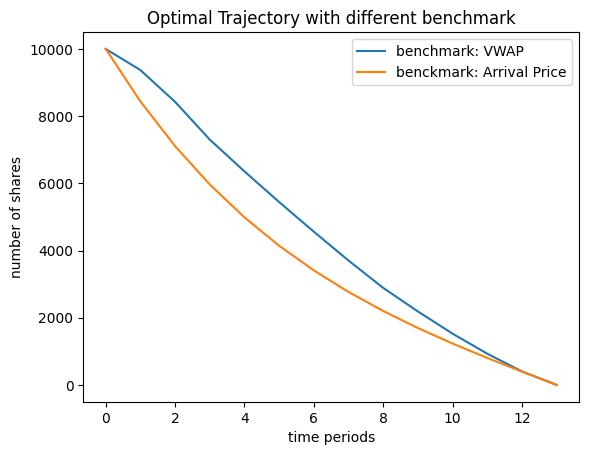

In [3]:
#see if the result is good

plt.plot(range(N + 1), optimal_execution(ts,EV_k,X,kappa),label = 'benchmark: VWAP')
plt.plot(range(N + 1), (np.sinh(kappa * (T - ts)) / np.sinh(kappa * T) ) * X,label = 'benckmark: Arrival Price')
plt.ylabel('number of shares')
plt.xlabel('time periods')
plt.title('Optimal Trajectory with different benchmark')
plt.legend()
plt.show()



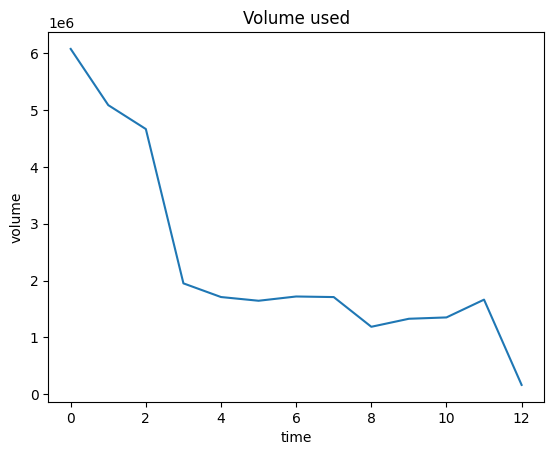

In [4]:
#we also the plot the volume prediction used in this simulation
plt.plot(range(N),vk)
plt.title('Volume used')
plt.xlabel('time')
plt.ylabel('volume')
plt.show()

We interpret the plot above. 

We see that comparing to the optimal execution under Arrival Price benchmark, the execution under VWAP price generally have 3 phase in execution: a fast execution, a slow execution, and a fast execution. This is consistent with our volume's projection that volume is generally higher at the begining and the end of the trading period. 

We also examine how the optimal execution changes with extreme input:

if all the volumes happens at the first time period

if all the volumes happens at the last period

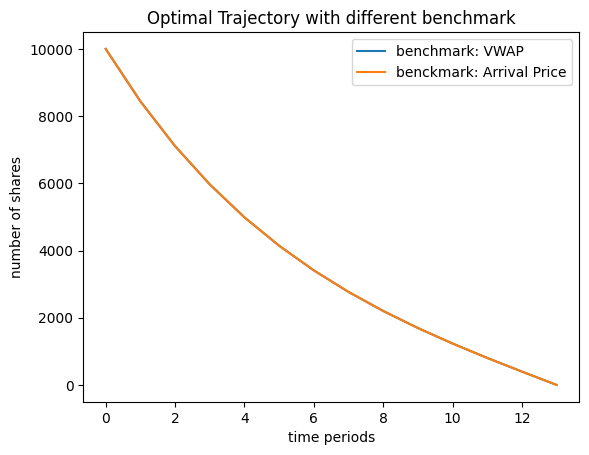

In [5]:
#first period
temp_vk = np.zeros(N)
temp_vk[0] = 1

plt.plot(range(N + 1), optimal_execution(ts,1 - cum_sum(temp_vk),X,kappa),label = 'benchmark: VWAP')
plt.plot(range(N + 1), (np.sinh(kappa * (T - ts)) / np.sinh(kappa * T) ) * X,label = 'benckmark: Arrival Price')

plt.ylabel('number of shares')
plt.xlabel('time periods')
plt.title('Optimal Trajectory with different benchmark')
plt.legend()
plt.show()




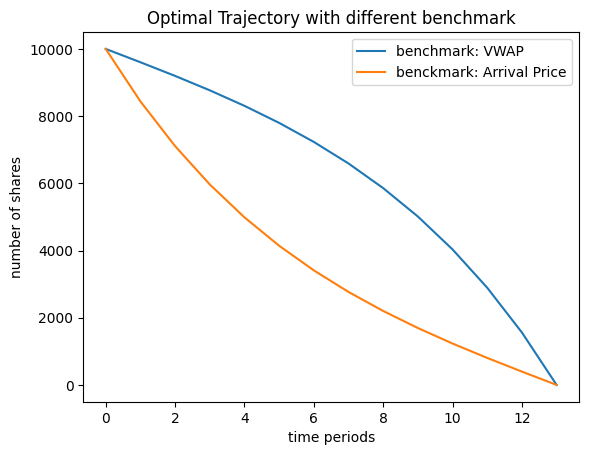

In [6]:
#first period
temp_vk = np.zeros(N)
temp_vk[-1] = 1

plt.plot(range(N + 1), optimal_execution(ts,1 - cum_sum(temp_vk),X,kappa),label = 'benchmark: VWAP')
plt.plot(range(N + 1), (np.sinh(kappa * (T - ts)) / np.sinh(kappa * T) ) * X,label = 'benckmark: Arrival Price')

plt.ylabel('number of shares')
plt.xlabel('time periods')
plt.title('Optimal Trajectory with different benchmark')
plt.legend()
plt.show()


we see that in the first case they actually overlaps. This is due to the fact that if all the volume happens at the first period, then effectively our volume weighted price is the arrival price, therefore the solution coincides, our execution adds as much front weight as allowed by the trading cost.

On the other hand, in the second case, where all the volume happens at the end, the trajectory effectively overtraded at every period, therefore it adds as much back weight as possible, also regulated by trading cost. 

In conclusion, for all volumes, our VWAP execution should lies within this region. 

In [7]:
#implement the cost function
#this function calculate the actual cost of the VWAP guarantee execution
def total_cost(xk,sigma,prices,volumes):
    '''
    This function calculate the total cost of a guaranteed VWAP execution of a given trajectory

    Args:
    xk (numpy array): the position at each time point
    sigma (float): the volitality of the stock. Should be volatility of stock return times stock arrival price
    prices (numpy array): stock's prices at each half hour time bucket
    volumes: stock's volume at each half hour time bucket

    Returns:
    tuple (float,float) : a tuple with 2 elements:
    1. the total trading cost incurred
    2. the total deviation from the benckmark price (VWAP)

    '''
    diffs = []
    for i in range(1,len(xk)):
        diffs.append(xk[i] - xk[i-1])
    nk = np.array(diffs)
    diffs = np.array(diffs) / ((T / N) * ADV)

    trading_cost = np.dot(nk,np.sign(diffs) * 1.5 * eta * sigma * np.sqrt(np.abs(diffs)))

    VWAP = np.dot(prices,volumes) / np.sum(volumes)
    X = xk[0]

    spread = X * VWAP - np.dot(-1 * nk,prices)

    return trading_cost , spread

In [8]:
def price_spread(sigma,X,ADV,EVK,EVK2,Lambda = 10**-6):
    '''
    This function calcuate the risk adjusted cost of a guaranteed VWAP execution

    Args:
    sigma (float): the volitality of the stock. Should be volatility of stock return times stock arrival price
    X (int): number of shares to execute ( positions to liquidate )
    ADV (int,float): Average daily value: calculated as average daily volume times arrival price
    EVK (numpy array): he expected cumulative volume at each time point, in fraction
    EVK2 (numpy array): the 2nd moment of the cumulative fractional volume of the day
    Lambda (float): risk aversion parameter. Translate varaince to cost. 

    Returns:
    float: the risk adjusted cost of guaranteed VWAP execution (per share)
    
    '''
    T = 1
    N = 13
    tau = T / N
    #sigma need to be price adjusted
    #ADV need to be price adjusted
    eta = 0.142

    kappa = np.sqrt(Lambda * sigma / (1.5 * eta * np.sqrt(1 / ADV)))

    ts = np.array([i * 1 / N for i in range(N + 1)])


    #solve for the optimal trading trajectory
    optimal_xk = optimal_execution(ts,EVK,X,kappa)
    
    #compute the estimated trading cost
    diffs = []
    for i in range(1,len(optimal_xk)):
        diffs.append(optimal_xk[i] - optimal_xk[i-1])
    nk = np.array(diffs)
    diffs = np.array(diffs) / ((T / N) * ADV)

    trading_cost = np.dot(nk,np.sign(diffs) * 1.5 * eta * sigma * np.sqrt(np.abs(diffs)))

    #compute the variance
    var = np.sum(sigma**2 * tau * (np.square(optimal_xk) - 2 * EVK * optimal_xk  * X + EVK2 * X**2))
    
    #return the risk adjusted cost per share
    return (trading_cost + Lambda * var) / X
